To complete this assignment, fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`, as well as your name below.

To make sure everything runs as expected, do the following
- **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
- **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

A good introduction to Jupyter notebooks is [here](https://realpython.com/jupyter-notebook-introduction/).


In [272]:
NAME = "Tianyi Xu"

---

# HW1 (50 points)

In this assignment we will build classifiers to classify a movie review as positive or negative. Using labeled data from IMDb, we will explore how to tokenize each document, create feature vectors, and implement a few different classifiers. Our goal is to understand the overall process of classification using machine learning, as well as to understand how to measure the impact of different algorithmic choices.

There are spaces below for you to both write code and short answers. In some places, there are tests to check your work, though passing tests does not guarantee full credit. I recommend moving sequentially from top to bottom, getting each step working before moving on to the next.

This assignment will use a number of Python libraries, including `pandas`, `sklearn`, `matplotlib`, `seaborn`, `numpy`, and `scipy`. If you haven't already installed these, you can do so by running this command in this directory: `pip install -r requirements.txt`. Minor variants in the version numbers shouldn't affect things much.

In [273]:
# imports
from collections import Counter
import copy
import numpy as np
from numpy import array as npa
import matplotlib.pyplot as plt
import math
import pandas as pd
import re
from scipy.sparse import csr_matrix
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB,MultinomialNB

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})
pd.set_option('display.max_colwidth', 100)

## Read and explore data

First, we'll read in the data, compute some basic statistics over it, and review some syntax of Pandas.

The training data is a tab-separated text file called `train.tsv`. We'll first read it into a Pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). If you haven't used Pandas before, it is a handy library to read and manipulate tabular data. [Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) is a nice overview.

In [274]:
# read training data into a Pandas DataFrame.
train_df = pd.read_csv('train.tsv', sep='\t')
train_df

,label,text
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the..."
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you..."
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...
...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu..."
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined..."
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi..."


In [275]:
# so, there are 200 positive and 200 negative documents
train_df.label.value_counts()

pos    200
neg    200
Name: label, dtype: int64

In [276]:
# we can get a column, which is a pandas.Series object, like this:
train_df.text  # or: train_df['text']

0      Here's another movie that should be loaded into a satellite, fired into space and pointed in the...
1      Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...
2      This is not "so bad that it is good," it is purely good! For those who don't understand why, you...
3      Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...
4      'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...
                                                      ...                                                 
395    This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...
396    ...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...
397    This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...
398    I watched SCARECROWS because o

In [277]:
# here's the 11th row
train_df.iloc[10]

label                                                                                                    pos
text     This is a film which had eluded me thus far but, now that I've watched it, emerges as one of the...
Name: 10, dtype: object

In [278]:
# here's how we can iterate over the DataFrame
for rowi, row in train_df.iterrows():
    print('row number:', rowi)
    print('label:', row['label'])
    print('text:', row['text'][:100])
    break

row number: 0
label: pos
text: Here's another movie that should be loaded into a satellite, fired into space and pointed in the dir


In [279]:
# we can add a new column by just assigning one.
# E.g., here we add a column indicating the character length of each document.
train_df['length'] = [len(d) for d in train_df.text]

In [280]:
# pandas has a pretty rich query language we can use to select rows. e.g.:
train_df[train_df.length > 100]

,label,text,length
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the...",4179
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...,886
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you...",810
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...,749
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...,586
...,...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...,692
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...",1560
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...",660
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi...",2859


In [281]:
train_df[(train_df.length>100) & (train_df.label=='neg')]

,label,text,length
200,neg,I feel totally ripped off. Someone needs to refund the $4.95 I spent at Blockbuster to rent this...,658
201,neg,I made a special effort to see this movie and was totally disappointed with the outcome. On pape...,892
202,neg,"Following the success of ""Paris, Je T'Aime"", a group of directors decided to get together and ma...",1915
203,neg,"Tony Goldwyn is a good actor who evidently is trying his hand at directing. ""A Walk on the Moon""...",2480
204,neg,"I am stunned to discover the amount of fans this show has. Haven't said that Friends was, at bes...",1670
...,...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...,692
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...",1560
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...",660
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi...",2859


Pandas supports [matplotlib](https://matplotlib.org/3.3.3/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) for plotting. E.g., here we plot a histogram of document lengths.

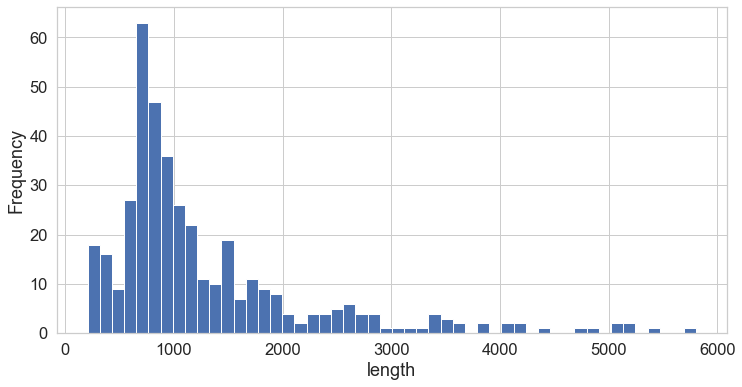

In [282]:
plt.figure()
train_df.length.plot.hist(bins=50)
plt.xlabel('length')
plt.show()

Does document length vary by label? Let's plot and see:

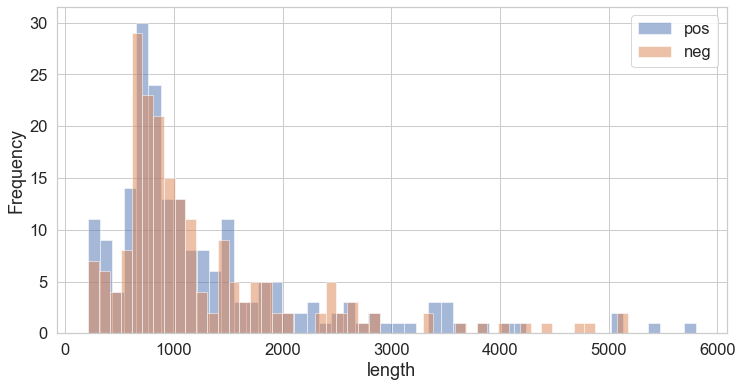

In [283]:
plt.figure()
train_df[train_df.label=='pos'].length.plot.hist(bins=50, label='pos', alpha=.5)
train_df[train_df.label=='neg'].length.plot.hist(bins=50, label='neg', alpha=.5)
plt.legend()
plt.xlabel('length')
plt.show()

Hmm...maybe. It does seem like very short documents are more likely to be positive than negative.

## Featurization

As we discussed in class, a first step in text classification is converting a document into a **feature vector**.

There are many things we can consider:

- Do we store word counts or just binary values (1 if word is present, 0 otherwise)?
- Do we keep punctuation?
- Do we keep capitalization?
- Do we just use words or also phrases?

There's no "best" answer to these questions. It is a tradeoff in the number of unique tokens in our model as well as the frequency with which we see each token in the training data. This will affect things like over/under fitting.

Below, complete the `tokenize` function, which takes as input a string representing a document, and returns a list of strings representing each token in the document. Part of your solution will use the `.split()` function of string objects. Then, we have two boolean flags:

- `ignore_case`: if True, convert the entire string to lowercase.
- `strip_punct`: if True, remove any leading or trailing punctuation for each token. E.g., "!it's?" would become "it's". You can use Python's [regular expression library](https://docs.python.org/3/library/re.html) library to do so. Hint: consider using the `sub` method combined with the `\w` and `\W` word classes.

In [284]:
def tokenize(document, strip_punct=True, ignore_case=True):
    # YOUR CODE HERE
    if ignore_case == True:
        document = document.lower()
    words = document.split( )
    if strip_punct == True:
        words = [re.sub('^\W*|\W*$', '', i) for i in words]
    return words

In [285]:
assert tokenize(" Hi there! Isn't this fun?", strip_punct=True, ignore_case=True) == ['hi', 'there', "isn't", 'this', 'fun']
assert tokenize(" Hi there! Isn't this fun?", strip_punct=False, ignore_case=True) == ['hi', 'there!', "isn't", 'this', 'fun?']

Next, we can choose a specific tokenization setting and apply it to all documents.

We'll store the results in a new column called `tokens`.

In [286]:
train_df['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in train_df.text]
train_df

,label,text,length,tokens
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the...",4179,"[here's, another, movie, that, should, be, loaded, into, a, satellite, fired, into, space, and, ..."
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...,886,"[cuban, blood, is, one, of, those, sleeper, films, that, has, a, lot, to, say, about, life, in, ..."
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you...",810,"[this, is, not, so, bad, that, it, is, good, it, is, purely, good, for, those, who, don't, under..."
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...,749,"[both, visually, and, musically, stunning, a, treat, for, both, the, eye, and, the, ear, the, qu..."
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...,586,"[cry, freedom, is, a, movie, about, how, far, people, will, go, to, find, the, truth.<br, br, th..."
...,...,...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...,692,"[this, movie, was, the, most, out, of, line, and, liberally, fed, movie, i, have, ever, seen, in..."
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...",1560,"[you, know, the, rest, if, you, want, a, good, zombie, movie, don't, rent, this, movie, if, you,..."
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...",660,"[this, was, longer, than, the, ten, commandments, all, lord, of, the, rings, and, the, matrix, t..."
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi...",2859,"[i, watched, scarecrows, because, of, the, buzz, surrounding, it, well, i, can't, imagine, anyon..."


Next we need to create a feature vector for each document. For now, we'll assume **binary features**, which means for each document we'll store a `dict` where words are keys and values are 1 for each word that exists in the document. 

In [287]:
def featurize(tokens):
    # YOUR CODE HERE
    return { token: 1 for token in tokens}

In [288]:
feats = featurize(tokenize(" Hi there! Isn't this fun? Hi there", strip_punct=True, ignore_case=True))
print(feats)
assert sorted(feats.items()) == [('fun', 1), ('hi', 1), ("isn't", 1), ('there', 1), ('this', 1)]
# note that sets and dicts are unordered; i'm sorting by alpha for testing purposes

{'hi': 1, 'there': 1, "isn't": 1, 'this': 1, 'fun': 1}


Now, we can featurize all the documents and assign to a new column called `raw_features`.

In [289]:
train_df['raw_features'] = [featurize(t) for t in train_df.tokens]
train_df

,label,text,length,tokens,raw_features
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the...",4179,"[here's, another, movie, that, should, be, loaded, into, a, satellite, fired, into, space, and, ...","{'here's': 1, 'another': 1, 'movie': 1, 'that': 1, 'should': 1, 'be': 1, 'loaded': 1, 'into': 1,..."
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...,886,"[cuban, blood, is, one, of, those, sleeper, films, that, has, a, lot, to, say, about, life, in, ...","{'cuban': 1, 'blood': 1, 'is': 1, 'one': 1, 'of': 1, 'those': 1, 'sleeper': 1, 'films': 1, 'that..."
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you...",810,"[this, is, not, so, bad, that, it, is, good, it, is, purely, good, for, those, who, don't, under...","{'this': 1, 'is': 1, 'not': 1, 'so': 1, 'bad': 1, 'that': 1, 'it': 1, 'good': 1, 'purely': 1, 'f..."
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...,749,"[both, visually, and, musically, stunning, a, treat, for, both, the, eye, and, the, ear, the, qu...","{'both': 1, 'visually': 1, 'and': 1, 'musically': 1, 'stunning': 1, 'a': 1, 'treat': 1, 'for': 1..."
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...,586,"[cry, freedom, is, a, movie, about, how, far, people, will, go, to, find, the, truth.<br, br, th...","{'cry': 1, 'freedom': 1, 'is': 1, 'a': 1, 'movie': 1, 'about': 1, 'how': 1, 'far': 1, 'people': ..."
...,...,...,...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...,692,"[this, movie, was, the, most, out, of, line, and, liberally, fed, movie, i, have, ever, seen, in...","{'this': 1, 'movie': 1, 'was': 1, 'the': 1, 'most': 1, 'out': 1, 'of': 1, 'line': 1, 'and': 1, '..."
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...",1560,"[you, know, the, rest, if, you, want, a, good, zombie, movie, don't, rent, this, movie, if, you,...","{'you': 1, 'know': 1, 'the': 1, 'rest': 1, 'if': 1, 'want': 1, 'a': 1, 'good': 1, 'zombie': 1, '..."
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...",660,"[this, was, longer, than, the, ten, commandments, all, lord, of, the, rings, and, the, matrix, t...","{'this': 1, 'was': 1, 'longer': 1, 'than': 1, 'the': 1, 'ten': 1, 'commandments': 1, 'all': 1, '..."
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi...",2859,"[i, watched, scarecrows, because, of, the, buzz, surrounding, it, well, i, can't, imagine, anyon...","{'i': 1, 'watched': 1, 'scarecrows': 1, 'because': 1, 'of': 1, 'the': 1, 'buzz': 1, 'surrounding..."


A common issue in text classification is that many words occur infrequently. This poses a challenge to any machine learning method -- if we've only seen a word once, we cannot be very confident about whether it correlates with the positive or negative class! First, let's count word frequencies by completing the method below. It takes in a list of `dict` objects, from the `raw_features` column, and returns a [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) object representing the number of documents each word appears in.

In [290]:
def count_word_document_frequency(dict_list):
    # YOUR CODE HERE
    return Counter([k for ks in [d.keys() for d in dict_list] for k in ks])
word_counts = count_word_document_frequency(train_df.raw_features)

In [291]:
# we should have 12,166 unique words
len(word_counts)

12166

In [292]:
# we can print the most common entries in a Counter like so:
word_counts.most_common(10)

[('the', 399),
 ('and', 392),
 ('a', 391),
 ('to', 380),
 ('of', 376),
 ('this', 364),
 ('is', 355),
 ('in', 350),
 ('it', 343),
 ('that', 327)]

In [293]:
assert count_word_document_frequency(train_df.raw_features).most_common(5) == [('the', 399), ('and', 392), ('a', 391), ('to', 380), ('of', 376)]

assert len(count_word_document_frequency(train_df.raw_features)) == 12166

Just how common are rare words? Let's plot a histogram to find out.

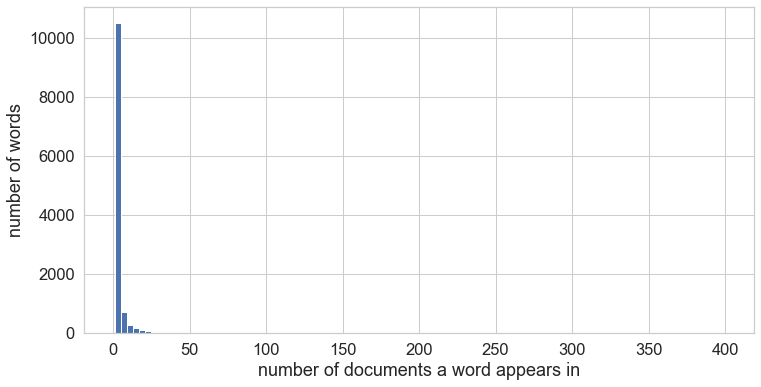

[(1, 7571), (2, 1698), (3, 804), (4, 438), (5, 268)]

In [294]:
plt.figure()
plt.hist(word_counts.values(), bins=100)
plt.xlabel('number of documents a word appears in')
plt.ylabel('number of words')
plt.show()
Counter(word_counts.values()).most_common(5)

**Whoa!** There are 7,571 out of 12,166 words that occur exactly once, and 1,698 that occur exactly twice.

This is very common in text collections. There are very many rare words and a small number of very common terms. This can sometimes be better seen in a `log-log` plot. These data somewhat follow something known as a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution, which just means this log-log plot is well-approximated by a linear fit.

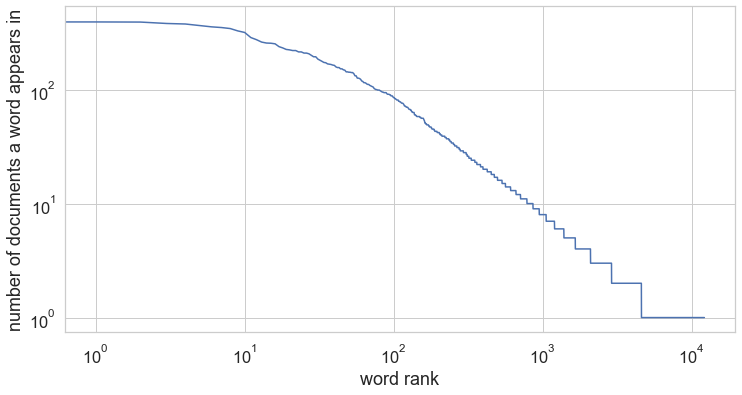

In [295]:
# log-log plot of word frequencies
def log_log_plot(word_counts):
    plt.figure()
    plt.loglog(sorted(word_counts.values())[::-1])
    plt.xlabel('word rank')
    plt.ylabel('number of documents a word appears in')
    plt.show()
    
log_log_plot(word_counts)

That long, horizontal segment at the bottom right of the plot represents the 7,571 words that occur exactly once.

The words at the top left are the most common words (`the`, `and`, etc.)

It seems that neither very common nor very rare words should be informative in our model.
- For very rare words, we don't see enough examples to have much confidence in our probability estimates.
- For very common words, if they appear in just about every document, they probably do not correlate with the class label.

We will next create a `vocabulary`, which contains our final set of unique features. To do so, we will remove terms that occur too frequently or too infrequently.

The inputs to `create_vocabulary` are:
- word_counts: the Counter object compute above
- min_count: minimum document count allowed
- max_count: maximum document count allowed

This function should return a `dict` where each key is a word and the value is a unique `int` representing the identifier for that word. We will assign each word its value in alphabetical order, e.g. `{'aardvark': 0, 'beetle': 1, ...}`

In [296]:
def create_vocabulary(word_counts, min_count=2, max_count=100):
    # YOUR CODE HERE
    idr = 0
    listv = {}
    for word in sorted(word_counts):
        if word_counts[word] >= min_count and word_counts[word] <= max_count:
            listv[word] = idr
            idr += 1
    return listv


vocabulary = create_vocabulary(word_counts, min_count=2, max_count=100)
list(vocabulary.items())[:10]

[('0', 0),
 ('1', 1),
 ('1/2', 2),
 ('10', 3),
 ('10/10', 4),
 ('100', 5),
 ('11', 6),
 ('12', 7),
 ('15', 8),
 ('16', 9)]

In [297]:
assert len(vocabulary) == 4519
assert list(vocabulary.items())[:10] == [('0', 0), ('1', 1), ('1/2', 2), ('10', 3), ('10/10', 4), ('100', 5), ('11', 6), ('12', 7), ('15', 8), ('16', 9)]

Now that we've finalized our vocabulary, we need to go back through all our `raw_features` in `train_df` and remove any that are not in this `vocabulary`. We store the result in a new column called `features`.

In [298]:
def prune_features(vocabulary, raw_feature_dict):
    return {k:v for k,v in raw_feature_dict.items() if k in vocabulary}

train_df['features'] = [prune_features(vocabulary, f) for f in train_df.raw_features]
train_df

,label,text,length,tokens,raw_features,features
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the...",4179,"[here's, another, movie, that, should, be, loaded, into, a, satellite, fired, into, space, and, ...","{'here's': 1, 'another': 1, 'movie': 1, 'that': 1, 'should': 1, 'be': 1, 'loaded': 1, 'into': 1,...","{'here's': 1, 'another': 1, 'should': 1, 'into': 1, 'fired': 1, 'space': 1, 'pointed': 1, 'direc..."
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...,886,"[cuban, blood, is, one, of, those, sleeper, films, that, has, a, lot, to, say, about, life, in, ...","{'cuban': 1, 'blood': 1, 'is': 1, 'one': 1, 'of': 1, 'those': 1, 'sleeper': 1, 'films': 1, 'that...","{'cuban': 1, 'blood': 1, 'those': 1, 'films': 1, 'lot': 1, 'say': 1, 'life': 1, 'traditional': 1..."
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you...",810,"[this, is, not, so, bad, that, it, is, good, it, is, purely, good, for, those, who, don't, under...","{'this': 1, 'is': 1, 'not': 1, 'so': 1, 'bad': 1, 'that': 1, 'it': 1, 'good': 1, 'purely': 1, 'f...","{'bad': 1, 'purely': 1, 'those': 1, 'don't': 1, 'understand': 1, 'why': 1, 'four': 1, 'year': 1,..."
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...,749,"[both, visually, and, musically, stunning, a, treat, for, both, the, eye, and, the, ear, the, qu...","{'both': 1, 'visually': 1, 'and': 1, 'musically': 1, 'stunning': 1, 'a': 1, 'treat': 1, 'for': 1...","{'both': 1, 'visually': 1, 'stunning': 1, 'treat': 1, 'eye': 1, 'ear': 1, 'quintessential': 1, '..."
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...,586,"[cry, freedom, is, a, movie, about, how, far, people, will, go, to, find, the, truth.<br, br, th...","{'cry': 1, 'freedom': 1, 'is': 1, 'a': 1, 'movie': 1, 'about': 1, 'how': 1, 'far': 1, 'people': ...","{'cry': 1, 'freedom': 1, 'how': 1, 'far': 1, 'people': 1, 'go': 1, 'find': 1, 'half': 1, 'intere..."
...,...,...,...,...,...,...
395,neg,This movie was the most out of line and liberally fed movie i have ever seen in my life. (Beside...,692,"[this, movie, was, the, most, out, of, line, and, liberally, fed, movie, i, have, ever, seen, in...","{'this': 1, 'movie': 1, 'was': 1, 'the': 1, 'most': 1, 'out': 1, 'of': 1, 'line': 1, 'and': 1, '...","{'most': 1, 'line': 1, 'fed': 1, 'ever': 1, 'seen': 1, 'life': 1, 'besides': 1, 'information': 1..."
396,neg,"...you know the rest. If you want a good zombie movie, DON'T RENT THIS MOVIE. If you want a docu...",1560,"[you, know, the, rest, if, you, want, a, good, zombie, movie, don't, rent, this, movie, if, you,...","{'you': 1, 'know': 1, 'the': 1, 'rest': 1, 'if': 1, 'want': 1, 'a': 1, 'good': 1, 'zombie': 1, '...","{'know': 1, 'rest': 1, 'want': 1, 'zombie': 1, 'don't': 1, 'rent': 1, 'look': 1, 'hood': 1, 'lif..."
397,neg,"This was longer than the Ten Commandments, All Lord of the Rings and the Matrix Trilogy combined...",660,"[this, was, longer, than, the, ten, commandments, all, lord, of, the, rings, and, the, matrix, t...","{'this': 1, 'was': 1, 'longer': 1, 'than': 1, 'the': 1, 'ten': 1, 'commandments': 1, 'all': 1, '...","{'longer': 1, 'ten': 1, 'matrix': 1, 'trilogy': 1, 'combined': 1, 'oh': 1, 'nightmare': 1, 'sing..."
398,neg,"I watched SCARECROWS because of the buzz surrounding it. Well, I can't imagine anyone liking thi...",2859,"[i, watched, scarecrows, because, of, the, buzz, surrounding, it, well, i, can't, imagine, anyon...","{'i': 1, 'watched': 1, 'scarecrows': 1, 'because': 1, 'of': 1, 'the': 1, 'buzz': 1, 'surrounding...","{'watched': 1, 'because': 1, 'surrounding': 1, 'well': 1, 'can't': 1, 'imagine': 1, 'anyone': 1,..."


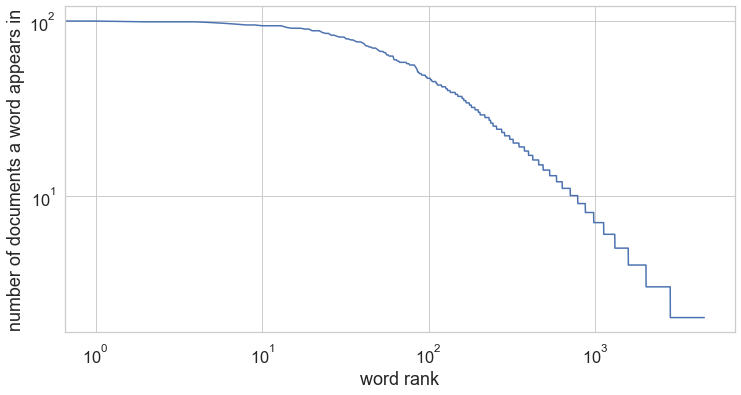

In [299]:
# just as a sanity check, let's plot the word frequency distribution again.
word_counts_pruned = count_word_document_frequency(train_df.features)
log_log_plot(word_counts_pruned)
# yes, we've chopped off the left and right part of the original graph.

## Naive Bayes

OK, now we're finally ready to fit a classifier. Let's start with Bernoulli Naive Bayes. Recall the formula to compute the word probabilities for each class, using smoothing:

$$p(x_{k}=1|y=1) = \frac{\epsilon + \sum_{(x_i, y_i) \in D}1[x_{ik}=1 \wedge y_i=1]}{2 \epsilon + \sum_{(x_i, y_i) \in D} 1[y_i=1]}$$

Commonly, $\epsilon=1$ is used (“plus one” smoothing). 

That is, the probability that word $k$ is present in a positive document is the fraction of positive documents that contain word $k$, modulo the smoothing terms.

To compute this, we'll first create a `dict` where keys are words and values are `p(x_{k}=1|y=1)`. We'll create a separate `dict` for $y=$pos and $y=$neg. You should be able to reuse your `count_word_document_frequency` method to help with this.

**note**: be sure to account for words that only appear in one class. These would only have value $\epsilon$ in the numerator.

In [300]:
def p_x_given_y(train_df, vocabulary, label, epsilon=0):
    # YOUR CODE HERE
    datas = train_df[train_df.label == label]
    #print(datas)
    word_count = count_word_document_frequency(datas.features)
    #print(word_count)
    totals = datas.label.count()
    #print(totals)
    listv = {}
    for i in vocabulary:
        number = 0 or word_count[i]
        listv[i] = (epsilon + number)/(2*epsilon + totals)
    return listv
    

p_x_given_pos = p_x_given_y(train_df, vocabulary, 'pos', epsilon=1)
p_x_given_neg = p_x_given_y(train_df, vocabulary, 'neg', epsilon=1)

In [301]:
assert round(p_x_given_neg['bad'], 3) == 0.307
assert round(p_x_given_pos['bad'], 3) == 0.139

# sanity check 

Let's look at the top values for each class.

In [302]:
print('top p(x|pos)')
print(sorted(p_x_given_pos.items(), key=lambda x: -x[1])[:15])

print('top p(x|neg)')
print(sorted(p_x_given_neg.items(), key=lambda x: -x[1])[:15])

top p(x|pos)
[('great', 0.3118811881188119), ('most', 0.2871287128712871), ('best', 0.28217821782178215), ('also', 0.27722772277227725), ('well', 0.27722772277227725), ('watch', 0.26732673267326734), ('we', 0.26732673267326734), ('people', 0.2623762376237624), ('many', 0.25742574257425743), ('too', 0.24752475247524752), ('then', 0.24257425742574257), ('its', 0.2376237623762376), ('think', 0.2376237623762376), ('were', 0.2376237623762376), ('does', 0.23267326732673269)]
top p(x|neg)
[('bad', 0.3069306930693069), ('made', 0.2722772277227723), ('make', 0.2722772277227723), ('how', 0.26732673267326734), ('were', 0.26732673267326734), ('because', 0.2623762376237624), ('into', 0.2623762376237624), ('then', 0.2623762376237624), ('being', 0.25742574257425743), ('could', 0.25742574257425743), ("don't", 0.2524752475247525), ('way', 0.24752475247524752), ('ever', 0.24257425742574257), ('them', 0.24257425742574257), ('too', 0.24257425742574257)]


It makes sense to see things like `great` and `best` in the positive class and `bad` in the negative class, but both distributions are dominated by very common terms -- e.g., `too` is very common in both classes.

To get a better sense of the relative frequency by class, we can simply subtract $p(x|pos)-p(x|neg)$ to find terms that are relatively more frequent in the positive class.

In [303]:
word_scores = pd.DataFrame([{'word':w, 'pos_score': p_x_given_pos[w] - p_x_given_neg[w]} for w in vocabulary])
print('positive terms')
display(word_scores.sort_values('pos_score', ascending=False).head(10))

print('negative terms')
display(word_scores.sort_values('pos_score', ascending=True).head(10))

positive terms


,word,pos_score
1794,great,0.148515
454,best,0.133663
4344,watch,0.103960
4464,worth,0.099010
161,again,0.084158
687,characters,0.079208
207,also,0.079208
2623,most,0.079208
4377,well,0.074257
2450,man,0.074257


negative terms


,word,pos_score
374,bad,-0.168317
4463,worst,-0.163366
2745,nothing,-0.143564
3978,terrible,-0.108911
4405,why,-0.099010
1402,ever,-0.099010
4341,waste,-0.099010
365,awful,-0.089109
511,boring,-0.089109
438,believe,-0.084158


These make more sense, though notice we still have some surprising words in the top 10 (e.g., `also`, `man`).

Let's stop and think some more about what smoothing is doing. Below we try different values of $\epsilon$ and print the top 5 terms for the positive class.

In [304]:
for e in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]:
    ppp = p_x_given_y(train_df, vocabulary, 'pos', epsilon=e)
    ppp = sorted(ppp.items(), key=lambda x: -x[1])
    print(ppp[:5])

[('great', 0.3118811881188119), ('most', 0.2871287128712871), ('best', 0.28217821782178215), ('also', 0.27722772277227725), ('well', 0.27722772277227725)]
[('great', 0.3137254901960784), ('most', 0.28921568627450983), ('best', 0.28431372549019607), ('also', 0.27941176470588236), ('well', 0.27941176470588236)]
[('great', 0.3155339805825243), ('most', 0.2912621359223301), ('best', 0.28640776699029125), ('also', 0.2815533980582524), ('well', 0.2815533980582524)]
[('great', 0.3173076923076923), ('most', 0.2932692307692308), ('best', 0.28846153846153844), ('also', 0.28365384615384615), ('well', 0.28365384615384615)]
[('great', 0.319047619047619), ('most', 0.29523809523809524), ('best', 0.2904761904761905), ('also', 0.2857142857142857), ('well', 0.2857142857142857)]
[('great', 0.32075471698113206), ('most', 0.2971698113207547), ('best', 0.29245283018867924), ('also', 0.28773584905660377), ('well', 0.28773584905660377)]
[('great', 0.32242990654205606), ('most', 0.29906542056074764), ('best', 

As $\epsilon$ increases to infinity, what value will $p(x|y)$ converge to? To answer this, just return the value in the method below (e.g., `return 0` or `return 100`).

In [305]:
def convergence_value():
    # return the float value that you think p(x|y) converges to as epsilon approaches infinity.
    # YOUR CODE HERE
    return 0.5

Think about this result and how it relates to the event model of Bernoulli Naive Bayes. E.g., a coin flip for each word.

The other quantity we need is $p(y=1)$, the prior probability. Since this is a binary classification task, we know that $p(y=0) = 1-p(y=1)$.

In [306]:
def compute_prior(df):
    """
    Compute the prior probability p(y=1) given a training set DataFrame.
    """
    # YOUR CODE HERE
    datas = df[df.label == 'pos']
    total_y1 = datas.label.count()
    p_y1 = total_y1/df.label.count() 
    return p_y1

prior = compute_prior(train_df)

In [307]:
assert round(compute_prior(train_df), 1) == 0.5


Now, let's actually classify a document using Naive Bayes. Recall the classification formula:

$$
p(y=1|\vec{x}) = \frac{p(y=1)\prod_j p(x_{ij}|y=1)}{p(\vec{x})}
$$

The product in the numerator must loop over all words in the vocabulary. Recall that:

$$
p(x_{ij}=0 \mid y=1) = 1 - p(x_{ij}=1 \mid y=1)
$$

Also, to prevent underflow, we'll have to use this equivalence:
$$
\log(p(y=1|\vec{x})) = \log(p(y=1)) + \sum_j \log p(x_{ij}|y=1) - \log(p(\vec{x}))
$$

where

$$\log(p(x)) = \log \Big( p(\vec{x}|y=1)p(y=1) + p(\vec{x}|y=0)p(y=0) \Big)$$

and to get the final answer:
$$p(y=1|\vec{x}) = \exp \Big( \log(p(y=1|\vec{x})) \Big)$$
(using `math.log` and `math.exp`)


Below, implement `log_p_y_given_x_numerator` which computes just the numerator:

$$\log(p(y)) + \sum_j \log p(x_{ij}|y)$$

Depending on what is passed in for `p_x_given_y` and `prior`, this will compute the numerator either for $y=1$ or $y=0$.

This function is then used by `pr_pos_given_x`, which is done for you, to compute $p(y=1|x)$



In [308]:
def log_p_y_given_x_numerator(features, p_x_given_y, prior, vocabulary):
    """
    returns log(p(y)) + \sum_j \log p(x_j|y). This is the numerator in the equation
    for p(y|x) above.
    
    note that p_x_given_y and prior can be values for y=1 or y=0, depending on what
    is passed in. see usage in pr_pos_given_x below.
    """
    # YOUR CODE HERE
    tprobability = 0
    for word in vocabulary:
        if word in features.keys():
            p = p_x_given_y[word]
        else:
            p = 1-p_x_given_y[word]
        tprobability += math.log(p)
    return math.log(prior) + tprobability

def pr_pos_given_x(features, p_x_given_pos, p_x_given_neg, prior, vocabulary):
    """
    Returns the probability p(y=1|x). This is complete and should not need to be modified.
    """
    pos_numerator = log_p_y_given_x_numerator(features, p_x_given_pos, prior, vocabulary)
    neg_numerator = log_p_y_given_x_numerator(features, p_x_given_neg, 1-prior, vocabulary)
    # there's an additional log-sum-exp trick to avoid underflow when computing p(x)
    # https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    maxv = max((pos_numerator, neg_numerator))
    log_p_x = maxv + math.log(math.exp(pos_numerator-maxv) + math.exp(neg_numerator-maxv))
    v = pos_numerator - log_p_x
    return math.exp(v)

In [309]:
assert round(pr_pos_given_x({'great': 1, 'most': 1, 'best': 1, 'well': 1}, p_x_given_pos, p_x_given_neg, prior, vocabulary), 2) == 0.82

In [310]:
assert round(pr_pos_given_x({'bad': 1, 'worst': 1, 'terrible': 1}, p_x_given_pos, p_x_given_neg, prior, vocabulary), 3) == 0.002

Now, we need to read in the testing data, compute features, and classify.

Here, we have to be very careful to process the data in the exact same way, to ensure our feature set is the same in both training and testing. This means the tokenizer is the same, and the features should be pruned to those in the vocabulary.

In [311]:
test_df = pd.read_csv('test.tsv', sep='\t')
test_df['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in test_df.text]
test_df['raw_features'] = [featurize(t) for t in test_df.tokens]
test_df['features'] = [prune_features(vocabulary, f) for f in test_df.raw_features]
test_df.head(2)

,label,text,tokens,raw_features,features
0,pos,"Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent ...","[of, the, korean, movies, i've, seen, only, three, had, really, stuck, with, me, the, first, is,...","{'of': 1, 'the': 1, 'korean': 1, 'movies': 1, 'i've': 1, 'seen': 1, 'only': 1, 'three': 1, 'had'...","{'movies': 1, 'i've': 1, 'seen': 1, 'three': 1, 'stuck': 1, 'excellent': 1, 'horror': 1, 'tale':..."
1,pos,"It started off weird, the middle was weird, and the ending was weird, but I really, really liked...","[it, started, off, weird, the, middle, was, weird, and, the, ending, was, weird, but, i, really,...","{'it': 1, 'started': 1, 'off': 1, 'weird': 1, 'the': 1, 'middle': 1, 'was': 1, 'and': 1, 'ending...","{'started': 1, 'off': 1, 'weird': 1, 'middle': 1, 'ending': 1, 'liked': 1, 'modern': 1, 'day': 1..."


Now, we can compute $p(y=1|x)$ for each training and testing instance. We'll store the result in a new column called `pr_pos`:

In [312]:
train_df['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos, p_x_given_neg, prior, vocabulary)
                      for f in train_df.features]
test_df['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos, p_x_given_neg, prior, vocabulary)
                     for f in test_df.features]
test_df.head(2)

,label,text,tokens,raw_features,features,pr_pos
0,pos,"Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent ...","[of, the, korean, movies, i've, seen, only, three, had, really, stuck, with, me, the, first, is,...","{'of': 1, 'the': 1, 'korean': 1, 'movies': 1, 'i've': 1, 'seen': 1, 'only': 1, 'three': 1, 'had'...","{'movies': 1, 'i've': 1, 'seen': 1, 'three': 1, 'stuck': 1, 'excellent': 1, 'horror': 1, 'tale':...",0.508402
1,pos,"It started off weird, the middle was weird, and the ending was weird, but I really, really liked...","[it, started, off, weird, the, middle, was, weird, and, the, ending, was, weird, but, i, really,...","{'it': 1, 'started': 1, 'off': 1, 'weird': 1, 'the': 1, 'middle': 1, 'was': 1, 'and': 1, 'ending...","{'started': 1, 'off': 1, 'weird': 1, 'middle': 1, 'ending': 1, 'liked': 1, 'modern': 1, 'day': 1...",0.975508


Next, we'll assign the predicted label as positive if the probability is $\ge .5$.

In [313]:
train_df['predicted_label'] = ['pos' if v >= .5 else 'neg' for v in train_df.pr_pos]
test_df['predicted_label'] = ['pos' if v >= .5 else 'neg' for v in test_df.pr_pos]
test_df.head(2)

,label,text,tokens,raw_features,features,pr_pos,predicted_label
0,pos,"Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent ...","[of, the, korean, movies, i've, seen, only, three, had, really, stuck, with, me, the, first, is,...","{'of': 1, 'the': 1, 'korean': 1, 'movies': 1, 'i've': 1, 'seen': 1, 'only': 1, 'three': 1, 'had'...","{'movies': 1, 'i've': 1, 'seen': 1, 'three': 1, 'stuck': 1, 'excellent': 1, 'horror': 1, 'tale':...",0.508402,pos
1,pos,"It started off weird, the middle was weird, and the ending was weird, but I really, really liked...","[it, started, off, weird, the, middle, was, weird, and, the, ending, was, weird, but, i, really,...","{'it': 1, 'started': 1, 'off': 1, 'weird': 1, 'the': 1, 'middle': 1, 'was': 1, 'and': 1, 'ending...","{'started': 1, 'off': 1, 'weird': 1, 'middle': 1, 'ending': 1, 'liked': 1, 'modern': 1, 'day': 1...",0.975508,pos


Finally, we can compute some quality metrics over the test set. We'll use [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) method from the sklearn library. Please read through the documentation to understand what these metrics are.

In [314]:
print('results on training data')
print(classification_report(train_df.label, train_df.predicted_label))
print('results on testing data')
print(classification_report(test_df.label, test_df.predicted_label))

results on training data
              precision    recall  f1-score   support

         neg       0.99      0.99      0.99       200
         pos       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

results on testing data
              precision    recall  f1-score   support

         neg       0.76      0.81      0.79       200
         pos       0.80      0.74      0.77       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



So, the overall accuracy is around 78%. Not bad for a simple method!

The precision and recall differ a bit by class, with `pos` having higher precision but lower recall. Based on these results, what is the more common type of error: classifying a negative document as positive (false positive) or classifying a positive document as negative (false negative)? **Submit your answer** by returning either "false positive" or "false negative" in the method below.


In [315]:
def error_type():
    # return either "false positive" or "false negative"
    # YOUR CODE HERE
    return "false negative"

## Logistic Regression

Next we'll look more closely at Logistic Regression. Below is the code from class to perform gradient descent, using negative log likelihood as the error function.

In [316]:
def gradient_descent(gradient_fn, error_fn, theta,
                     learning_rate, D, tolerance, max_iters):
    errori = error_fn(theta, D)
    iters = 0
    trace = [] # for debugging
    while True:
        iters += 1
        theta_cp = copy.copy(theta)
        print('\n\niteration %d' % iters)
        grad = gradient_fn(theta, D)
        trace.append((theta.copy(), grad, errori))
        print('gradient=', grad)
        theta -= learning_rate * grad  # UPDATE!
        newerror = error_fn(theta, D)
        print('old error=%g   new error=%g  theta=%s\n\n' %
              (errori, newerror, str(theta)))
        error_diff = errori - newerror
        # stopping criteria
        if error_diff < 0:
            learning_rate *= .5
            print('error got worse. reducing learning rate to %g' % learning_rate)
            theta = theta_cp
            errori = error_fn(theta, D)
        elif errori - newerror < tolerance:
            print('error change is too small')
            break
        elif iters >= max_iters:
            print('max iterations reached')
            break
        else:
            errori = newerror
    trace = pd.DataFrame(trace, columns=['theta', 'gradient', 'error'])
    display(trace)
    plt.plot(trace.error, 'bo-')
    plt.xlabel('iteration')
    plt.ylabel('error')
    return theta

def f(x, theta):
    # dot product
    return x.dot(theta)

def logistic(x, theta):
    # logistic function: p(y=1|x)
    return 1 / (1 + math.exp(-f(x, theta)))

def nll(theta, D):
    # negative log likelihood
    total = 0
    predictions = [] # for debugging
    for xi, yi in D:
        pred = logistic(xi, theta) if yi==1 else 1-logistic(xi, theta)
        total += math.log(pred)
        predictions.append((xi, yi, pred, 1-pred))
    display(pd.DataFrame(predictions, columns=['x', 'y', 'prediction', 'error']))        
    return -total

def gradient_logistic(theta, D):
    # gradient function for logistic regression
    # updated from lecture to use csr_matrix as feature vectors, 
    # instead of numpy arrays.
    result = np.zeros(len(theta), dtype=np.float64)
    for xi, yi in D:
        p_y_g_x = logistic(xi, theta) if yi==1 else 1-logistic(xi, theta)
        error = yi * (1-p_y_g_x)
        for j, xij in zip(xi.indices, xi.data):
            result[j] += error * xij
    return -result

This code expects the features of a document to be a `numpy array`, rather than a `dict` like we used in naive bayes.

Complete the code below, which creates a numpy array from a feature `dict`. The array should have `1` at location `i` if word `i` is present in the feature dictionary. The order of the array is deterined by the `vocabulary` object.

In [317]:
def features2array(features, vocabulary):
    # YOUR CODE HERE
    leng = len(vocabulary)
    listf = np.zeros(leng)
    for i in vocabulary:
        if i in features:
            listf[vocabulary[i]] = 1
    return listf

In [318]:
feature_vector = features2array({'great': 1, 'terrible': 1}, vocabulary)
assert len(feature_vector) == len(vocabulary)
assert feature_vector[vocabulary['great']] == 1.0
assert feature_vector[vocabulary['terrible']] == 1.0
assert feature_vector[vocabulary['also']] == 0.0

This vector representation is very space inefficient. Since most documents only use a small subset of the full vocabulary, most values will be zero in the feature vector. E.g., below is the number of 0 and 1 values stored in the first training document:

In [319]:
Counter(features2array(train_df.features[0], vocabulary))

Counter({0.0: 4271, 1.0: 248})

We will instead use a [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), which is a sparse representation of an array. It only stores the non-zero values, along with some indices keeping track of which column each non-zero value correponds to. Below, I've given you the function to do this. We can see that it saves about 33kb just for the first document.

In [320]:
def features2sparse_array(features, vocabulary):
    return csr_matrix(features2array(features, vocabulary), shape=(1, len(vocabulary)))

dense_array = features2array(train_df.features[0], vocabulary)
sparse_array = features2sparse_array(train_df.features[0], vocabulary)
print('document contains %d/%d words' % (sparse_array.nnz, len(vocabulary)))
print('dense array requires %d bytes, sparse array requires %d bytes' % 
      (dense_array.nbytes, sparse_array.data.nbytes + sparse_array.indices.nbytes + sparse_array.indptr.nbytes))

document contains 248/4519 words
dense array requires 36152 bytes, sparse array requires 2984 bytes


Now, we will add these sparse arrays to our training and testing DataFrames.

In [321]:
train_df['feature_vector'] = [features2sparse_array(f, vocabulary) for f in train_df.features]
test_df['feature_vector'] = [features2sparse_array(f, vocabulary) for f in test_df.features]
train_df.head(1)

,label,text,length,tokens,raw_features,features,pr_pos,predicted_label,feature_vector
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the...",4179,"[here's, another, movie, that, should, be, loaded, into, a, satellite, fired, into, space, and, ...","{'here's': 1, 'another': 1, 'movie': 1, 'that': 1, 'should': 1, 'be': 1, 'loaded': 1, 'into': 1,...","{'here's': 1, 'another': 1, 'should': 1, 'into': 1, 'fired': 1, 'space': 1, 'pointed': 1, 'direc...",1.0,pos,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0..."


Next, let's create the full training dataset $D$, which is a list of tuples of the form (feature_vector, label).

In [322]:
D = [(fv, 1 if label=='pos' else -1) for label, fv in train_df[['label', 'feature_vector']].values]

Now we will create an initial $\theta$ vector of 0s and call gradient descent.

,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,0.5,0.5
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,0.5,0.5
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.5,0.5
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,0.5,0.5
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.5,0.5
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.5,0.5
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,0.5,0.5
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.5,0.5
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,0.5,0.5




iteration 1
gradient= [ 1.5  7.   1.  ...  2.  -0.  -1. ]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,0.999994,6.144175e-06
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.078801e-10
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999932,6.772415e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,2.653424e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999980,2.039909e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.999590,4.095672e-04
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,7.250089e-12
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999990,9.635950e-06
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=277.259   new error=57.0919  theta=[-0.45 -2.1  -0.3  ... -0.6   0.    0.3 ]




iteration 2
gradient= [ 1.12503007e-10  6.08090014e-01  5.22029358e-03 ...  7.25008942e-12
 -5.66213743e-13 -7.68524793e-01]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,2.668437e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,3.272405e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999982,1.815756e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,9.892567e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999938,6.226220e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997835,2.164517e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,5.623546e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999982,1.806561e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=57.0919   new error=2.26915  theta=[-4.50000000e-01 -2.28242700e+00 -3.01566088e-01 ... -6.00000000e-01
  1.69864123e-13  5.30557438e-01]




iteration 3
gradient= [ 4.99190689e-11  1.55915624e-01  2.21251897e-03 ...  5.62354607e-11
 -8.04001310e-12 -2.09441782e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,0.999999,5.008462e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,2.842326e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999973,2.691565e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,9.027321e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999944,5.560356e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.998225,1.774727e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,3.110279e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999985,1.486532e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=2.26915   new error=1.11721  theta=[-4.50000000e-01 -2.32920169e+00 -3.02229844e-01 ... -6.00000000e-01
  2.58186805e-12  5.30620270e-01]




iteration 4
gradient= [ 3.02565750e-11  5.71072855e-02  9.62219071e-04 ...  3.11027870e-11
 -1.54616320e-11 -2.51905434e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.667302e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,2.075362e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999980,2.024474e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,6.866587e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999954,4.614024e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997677,2.322914e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,5.947087e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999982,1.848752e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=1.11721   new error=0.766601  theta=[-4.50000000e-01 -2.34633388e+00 -3.02518509e-01 ... -6.00000000e-01
  7.22035765e-12  5.30695842e-01]




iteration 5
gradient= [ 4.53608262e-11  6.25837924e-02  1.00747232e-03 ...  5.94708727e-11
 -7.40985051e-12 -2.09468395e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.472262e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.994560e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999980,2.017020e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,6.322225e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999955,4.502721e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997648,2.352140e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.453738e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999981,1.912554e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.766601   new error=0.639886  theta=[-4.50000000e-01 -2.36510901e+00 -3.02820751e-01 ... -6.00000000e-01
  9.44331280e-12  5.30758683e-01]




iteration 6
gradient= [ 4.73193706e-11  5.07471474e-02  8.80084437e-04 ...  6.45373754e-11
 -6.93756164e-12 -2.10481962e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.372844e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.941958e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999980,2.025213e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.961962e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999956,4.446400e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997655,2.345415e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.699175e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,1.951607e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.639886   new error=0.557163  theta=[-4.50000000e-01 -2.38033316e+00 -3.03084777e-01 ... -6.00000000e-01
  1.15245813e-11  5.30821827e-01]




iteration 7
gradient= [ 4.83829643e-11  4.26650281e-02  7.83216176e-04 ...  6.69917455e-11
 -6.71129818e-12 -2.12196945e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.308680e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.899636e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999980,2.036432e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.693455e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999956,4.411741e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997677,2.323340e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.824008e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,1.978647e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.557163   new error=0.497484  theta=[-4.50000000e-01 -2.39313267e+00 -3.03319741e-01 ... -6.00000000e-01
  1.35379707e-11  5.30885486e-01]




iteration 8
gradient= [ 4.90668617e-11  3.68952216e-02  7.07619930e-04 ...  6.82400803e-11
 -6.57141008e-12 -2.13828285e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.262415e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.862799e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999980,2.047962e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.480476e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999956,4.388172e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997707,2.293233e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.882039e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,1.998453e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.497484   new error=0.451759  theta=[-4.50000000e-01 -2.40420123e+00 -3.03532027e-01 ... -6.00000000e-01
  1.55093938e-11  5.30949635e-01]




iteration 9
gradient= [ 4.95387065e-11  3.25744884e-02  6.46762540e-04 ...  6.88203938e-11
 -6.47304432e-12 -2.15263422e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.226707e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.829603e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.058969e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.304672e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999956,4.371107e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997741,2.258679e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.899914e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,2.013453e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.451759   new error=0.41527  theta=[-4.50000000e-01 -2.41397358e+00 -3.03726056e-01 ... -6.00000000e-01
  1.74513071e-11  5.31014214e-01]




iteration 10
gradient= [ 4.98769914e-11  2.92152634e-02  5.96541020e-04 ...  6.89991397e-11
 -6.39754916e-12 -2.16499119e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.197819e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.799116e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.069175e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.155441e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999956,4.358211e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997778,2.221696e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.892498e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,2.025067e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.41527   new error=0.385282  theta=[-4.50000000e-01 -2.42273816e+00 -3.03905018e-01 ... -6.00000000e-01
  1.93705718e-11  5.31079164e-01]




iteration 11
gradient= [ 5.01246822e-11  2.65260852e-02  5.54279338e-04 ...  6.89249768e-11
 -6.33626485e-12 -2.17555280e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.173628e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.770806e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.078511e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,5.026111e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.348170e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997816,2.183502e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.868706e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,2.034196e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.385282   new error=0.360082  theta=[-4.50000000e-01 -2.43069599e+00 -3.04071302e-01 ... -6.00000000e-01
  2.12714513e-11  5.31144430e-01]




iteration 12
gradient= [ 5.03080910e-11  2.43225799e-02  5.18152468e-04 ...  6.86870560e-11
 -6.28341823e-12 -2.18455382e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.152837e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.744338e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.086991e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.912220e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.340186e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997855,2.144866e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.834144e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,2.041439e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.360082   new error=0.33853  theta=[-4.50000000e-01 -2.43799276e+00 -3.04226748e-01 ... -6.00000000e-01
  2.31564767e-11  5.31209967e-01]




iteration 13
gradient= [ 5.04440933e-11  2.24824698e-02  4.86867398e-04 ...  6.83414436e-11
 -6.23678886e-12 -2.19221309e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.134605e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.719469e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.094668e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.810650e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.333750e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997894,2.106284e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.792455e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999980,2.047217e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.33853   new error=0.319836  theta=[-4.50000000e-01 -2.44473750e+00 -3.04372808e-01 ... -6.00000000e-01
  2.50275134e-11  5.31275733e-01]




iteration 14
gradient= [ 5.05439024e-11  2.09214509e-02  4.59478931e-04 ...  6.79245549e-11
 -6.19393425e-12 -2.19872100e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.118367e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.695999e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.101605e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.719130e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.328517e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997932,2.068084e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.746081e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.051830e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.319836   new error=0.30343  theta=[-4.50000000e-01 -2.45101394e+00 -3.04510652e-01 ... -6.00000000e-01
  2.68856937e-11  5.31341695e-01]




iteration 15
gradient= [ 5.06152897e-11  1.95795024e-02  4.35278065e-04 ...  6.74608147e-11
 -6.15441031e-12 -2.20423906e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.103723e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.673794e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.107870e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.635965e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.324247e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.997970,2.030479e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.696654e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.055503e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.30343   new error=0.28889  theta=[-4.50000000e-01 -2.45688779e+00 -3.04641235e-01 ... -6.00000000e-01
  2.87320168e-11  5.31407822e-01]




iteration 16
gradient= [ 5.06641396e-11  1.84127229e-02  4.13721361e-04 ...  6.69665434e-11
 -6.11688478e-12 -2.20890291e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.090385e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.652722e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.113526e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.559848e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.320767e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.998006,1.993612e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.645362e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.058405e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.28889   new error=0.275895  theta=[-4.50000000e-01 -2.46241160e+00 -3.04765352e-01 ... -6.00000000e-01
  3.05670822e-11  5.31474089e-01]




iteration 17
gradient= [ 5.06944486e-11  1.73882551e-02  3.94384567e-04 ...  6.64536204e-11
 -6.08113560e-12 -2.21282615e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.078135e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.632716e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.118632e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.489760e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.317946e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.998042,1.957571e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.592993e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.060667e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.275895   new error=0.264196  theta=[-4.50000000e-01 -2.46762808e+00 -3.04883667e-01 ... -6.00000000e-01
  3.23914229e-11  5.31540474e-01]




iteration 18
gradient= [ 5.07094366e-11  1.64810147e-02  3.76931194e-04 ...  6.59299282e-11
 -6.04671868e-12 -2.21610408e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.066809e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.613643e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.123242e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.424880e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.315684e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.998078,1.922412e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.540146e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.062392e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.264196   new error=0.253596  theta=[-4.50000000e-01 -2.47257238e+00 -3.04996746e-01 ... -6.00000000e-01
  3.42054385e-11  5.31606957e-01]




iteration 19
gradient= [ 5.07116571e-11  1.56715178e-02  3.61090647e-04 ...  6.54014620e-11
 -6.01363404e-12 -2.21881682e-04]


,x,y,prediction,error
0,"(0, 4)\t1.0\n (0, 19)\t1.0\n (0, 20)\t1.0\n (0, 117)\t1.0\n (0, 122)\t1.0\n (0, 146)\t1.0...",1,1.000000,1.056278e-07
1,"(0, 6)\t1.0\n (0, 17)\t1.0\n (0, 18)\t1.0\n (0, 112)\t1.0\n (0, 122)\t1.0\n (0, 164)\t1.0...",1,1.000000,1.595457e-11
2,"(0, 86)\t1.0\n (0, 170)\t1.0\n (0, 266)\t1.0\n (0, 374)\t1.0\n (0, 593)\t1.0\n (0, 664)\t...",1,0.999979,2.127403e-05
3,"(0, 137)\t1.0\n (0, 516)\t1.0\n (0, 735)\t1.0\n (0, 751)\t1.0\n (0, 838)\t1.0\n (0, 945)\...",1,1.000000,4.364549e-10
4,"(0, 115)\t1.0\n (0, 209)\t1.0\n (0, 257)\t1.0\n (0, 295)\t1.0\n (0, 462)\t1.0\n (0, 979)\...",1,0.999957,4.313904e-05
...,...,...,...,...
395,"(0, 65)\t1.0\n (0, 161)\t1.0\n (0, 163)\t1.0\n (0, 441)\t1.0\n (0, 453)\t1.0\n (0, 970)\t...",-1,0.998112,1.888164e-03
396,"(0, 24)\t1.0\n (0, 41)\t1.0\n (0, 112)\t1.0\n (0, 254)\t1.0\n (0, 260)\t1.0\n (0, 263)\t1...",-1,1.000000,6.487233e-11
397,"(0, 36)\t1.0\n (0, 54)\t1.0\n (0, 112)\t1.0\n (0, 161)\t1.0\n (0, 469)\t1.0\n (0, 545)\t1...",-1,0.999979,2.063662e-05
398,"(0, 43)\t1.0\n (0, 112)\t1.0\n (0, 114)\t1.0\n (0, 122)\t1.0\n (0, 159)\t1.0\n (0, 161)\t...",-1,1.000000,0.000000e+00


old error=0.253596   new error=0.24394  theta=[-4.50000000e-01 -2.47727384e+00 -3.05105074e-01 ... -6.00000000e-01
  3.60095287e-11  5.31673521e-01]


error change is too small


,theta,gradient,error
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.5, 7.0, 1.0, 1.0, -2.5, -1.0, -0.0, 1.5, -0.5, -1.5, -0.0, -1.0, -1.0, -0.0, -1.0, -1.0, -0.0...",277.258872
1,"[-0.44999999999999996, -2.1, -0.3, -0.3, 0.75, 0.3, 0.0, -0.44999999999999996, 0.15, 0.449999999...","[1.1250300691045823e-10, 0.6080900144035751, 0.005220293576283286, -1.7089798024535814, -9.76845...",57.091940
2,"[-0.45000000003375085, -2.2824270043210726, -0.301566088072885, 0.21269394073607445, 0.750029305...","[4.9919068878523376e-11, 0.15591562413947013, 0.0022125189662107747, 0.0735874147765786, -2.5414...",2.269149
3,"[-0.4500000000487266, -2.3292016915629135, -0.3022298437627482, 0.19061771630310087, 0.750036929...","[3.0256575023202004e-11, 0.05710728553993605, 0.0009622190706068956, -0.005573665906802527, -3.8...",1.117207
4,"[-0.45000000005780355, -2.346333877224894, -0.3025185094839303, 0.19228981607514162, 0.750048441...","[4.536082620631987e-11, 0.062583792376815, 0.0010074723151668463, 0.030129381566895597, -2.67558...",0.766601
5,"[-0.4500000000714118, -2.3651090149379383, -0.30282075117848034, 0.18325100160507293, 0.75005646...","[4.731937064406111e-11, 0.050747147432130046, 0.0008800844365259852, 0.023892760710169103, -2.66...",0.639886
6,"[-0.4500000000856076, -2.380333159167577, -0.30308477650943816, 0.1760831733920222, 0.7500644521...","[4.838296430165201e-11, 0.04266502806535377, 0.0007832161757491685, 0.019549985213293097, -2.684...",0.557163
7,"[-0.4500000001001225, -2.3931326675871833, -0.3033197413621629, 0.17021817782803428, 0.750072504...","[4.9066861684821106e-11, 0.036895221592604166, 0.0007076199300303232, 0.01651681398153859, -2.71...",0.497484
8,"[-0.45000000011484254, -2.4042012340649648, -0.30353202734117196, 0.1652631336335727, 0.75008065...","[4.95387064702868e-11, 0.03257448842867694, 0.0006467625402839516, 0.014298783025016082, -2.7557...",0.451759
9,"[-0.45000000012970415, -2.413973580593568, -0.30372605610325715, 0.16097349872606787, 0.75008892...","[4.987699142589008e-11, 0.029215263415339643, 0.0005965410197098509, 0.012611056048320912, -2.79...",0.415270


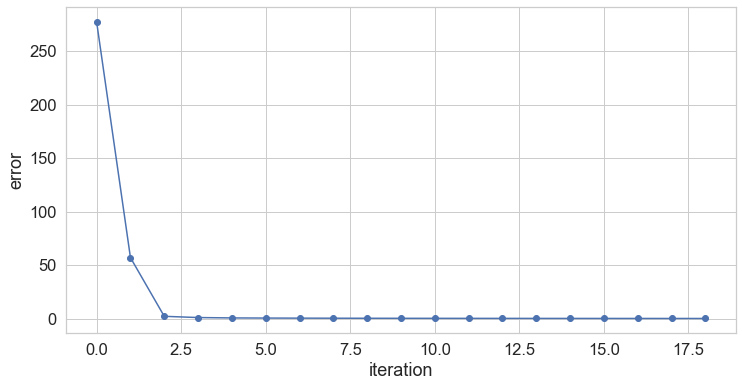

In [323]:
theta = np.zeros(len(vocabulary))
theta = gradient_descent(gradient_logistic, nll, theta, .3, D, .01, 20)

In [324]:
# print accuracy on training and testing data
print('results on training data')
train_df['pr_pos_lr'] = [logistic(features2sparse_array(f, vocabulary), theta) for f in train_df.features]
train_df['predicted_label_lr'] = ['pos' if v >= .5 else 'neg' for v in train_df.pr_pos_lr]
print(classification_report(train_df.label, train_df.predicted_label_lr))

print('results on testing data')
test_df['pr_pos_lr'] = [logistic(features2sparse_array(f, vocabulary), theta) for f in test_df.features]
test_df['predicted_label_lr'] = ['pos' if v >= .5 else 'neg' for v in test_df.pr_pos_lr]
print(classification_report(test_df.label, test_df.predicted_label_lr))

results on training data
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       200
         pos       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

results on testing data
              precision    recall  f1-score   support

         neg       0.79      0.79      0.79       200
         pos       0.79      0.80      0.79       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



We can see that the classifier has perfect accuracy on the training data, and similar accuracy as naive bayes on the test data.

<br><br>

Now, let's inspect the $\theta$ coefficients. Here are the largest and smallest values:

In [325]:
# print top coefficients for each class.
reverse_vocab = {i:v for v,i in vocabulary.items()}
for i in np.argsort(theta)[::-1][:15]:
    print(reverse_vocab[i], theta[i])
print()
for i in np.argsort(theta)[:15]:
    print(reverse_vocab[i], theta[i])

great 3.9849314068672625
best 3.5021885924358807
worth 3.03503267699398
again 2.8509808811500124
watch 2.6970337271289457
excellent 2.452009979546707
characters 2.3105321539993726
where 2.305209268892795
role 2.230428438006598
himself 2.2163805179363893
course 2.202118766254539
also 2.18438409816463
most 2.1577424641319984
times 2.0580443799019243
man 2.028296057308245

worst -4.989780545191388
nothing -4.731229882969549
bad -4.550875085951399
terrible -3.2994496733451992
waste -3.0047891911913376
boring -2.7572465178605774
why -2.753304627428758
awful -2.6914029701534026
because -2.661547887241208
poor -2.5532211617311655
believe -2.517191197830231
almost -2.482609778237899
1 -2.477273839238819
looks -2.4735308515133188
being -2.357639101274552


Inspecting coefficients is a good way to understand your data better. For example, the word "1" appears to be strongly associated with the negative class. Do some digging in the original data to figure out why. In what context does the number "1" appear, and why is it correlated with the negative class? 

**Write your answer in the cell below.**

I print the labels of the training context that number "1" appear. And we can find that in the original data, row number ID of texts that No. 12, 54, 71, 126, 207, 224, 266, 273, 274, 278, 308, 310, 319, 326, 355,357,358,360, 362, 367, 376, 378 texts appear "1". Among them, there are 4 positive and 18 negative, and the number of negative is far more than positive. In the process of theta updates, the more negative text appear, the smaller the value of theta will be, or even negative. 

In addition, from the content of these context, I find that some text with "1" just because "1" is a rating score for movies. And it's a lower level score, so that the text will explain why this score produces, which produces long length text. Also some "1"s are about the order number, with these "1"s, the text explain many why this happens and also produces long length text. From previous analysis, we know long length text will be negative with more probability.

But, how should we interpret these coefficients? What does a coefficient of $3.98$ tell us about the term `great`?

In linear regression, we know that the coefficient $\theta_i$ represents the strength of the linear relationship between the independent and dependent variables. That is, as the independent variable ($x_i$) increases by one unit, we expect the dependent variable ($y$) to increase by $\theta_i$.

This is a bit more complicated for logistic regression, since the logistic function introduces a non-linear relationship between $x$ and $y$.

One approach is to just pass the coefficient through the logistic function. This tells us the probability that a document containing just this single word is positive.

In [327]:
def logistic_single(x):
    return 1 / (1+math.exp(-x))


print("p(y=1|great)=%.3f" % logistic_single(theta[vocabulary['great']]))
print("p(y=1|terrible)=%.3f" % logistic_single(theta[vocabulary['terrible']]))

p(y=1|great)=0.982
p(y=1|terrible)=0.036


## sklearn

Now, we did all this the hard way to understand how this works. Of course, there are libraries that do most of these steps for us. E.g., [`sklearn`](https://scikit-learn.org/stable/index.html) is a popular machine learning library; a good tutorial is [here](https://www.datacamp.com/community/tutorials/machine-learning-python).

For example, the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?highlight=countvectorizer#sklearn.feature_extraction.text.CountVectorizer) class in sklearn provides a way to extract tokens and features from raw text. 

In [328]:
vec = CountVectorizer(max_df=100, min_df=2, binary=True)
X_train = vec.fit_transform(train_df.text)
#print(X_train)
X_test = vec.transform(test_df.text)
print('X_train is a csr_matrix with %d rows and %d columns' % (X_train.shape[0], X_train.shape[1]))
print('vec.vocabulary_ maps words to indices. E.g., "great" has index %d' % vec.vocabulary_['great'])

X_train is a csr_matrix with 400 rows and 4525 columns
vec.vocabulary_ maps words to indices. E.g., "great" has index 1807


sklearn has a number of classifiers implemented, including [Bernoulli](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html?highlight=bernoulli#sklearn.naive_bayes.BernoulliNB) and [Multinomial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomial#sklearn.naive_bayes.MultinomialNB) Naive Bayes, and [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression)

In [329]:
nb = BernoulliNB(alpha=1)
nb.fit(X_train, train_df.label)
y_pred = nb.predict(X_test)
print(classification_report(test_df.label, y_pred))

              precision    recall  f1-score   support

         neg       0.76      0.82      0.79       200
         pos       0.80      0.73      0.77       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



The accuracy is pretty close to what we got above. There are some small differences in the vocabulary.

We can find the word probabilities in `nb.feature_log_prob`, which stores $\log p(x_i \mid y)$ for each class. We can exponentiate to get the probabilities.

In [330]:
# these should be similar to what we calculated above in our own implementation.
great_idx = vec.vocabulary_['great']
print('p(great|y=1)=%.2f' % math.exp(nb.feature_log_prob_[1][great_idx]))
print('p(great|y=0)=%.2f' % math.exp(nb.feature_log_prob_[0][great_idx]))

p(great|y=1)=0.31
p(great|y=0)=0.17


We can similarly fit LogisticRegression.

In [331]:
# Since we didn't use any regularization in our implementation above,
# I'm setting C to a large number to reduce the effect of the L2 regularizer.
lr = LogisticRegression(C=1e10)
lr.fit(X_train, train_df.label)
y_pred_lr = lr.predict(X_test)
print(classification_report(test_df.label, y_pred_lr))

              precision    recall  f1-score   support

         neg       0.77      0.77      0.77       200
         pos       0.77      0.78      0.77       200

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our accuracy is pretty close to our implementation above. 

We can find the $\theta$ coefficients in `lr.coef_`.

In [332]:
print('theta for "great" is %.3f' % lr.coef_[0][great_idx])

theta for "great" is 1.602


## Engineering

Now that you understand a bit more about logistic regression and naive bayes, explore `sklearn` for a while to see if you can come up with an approach that has higher test accuracy than we've shown above. A few ground rules:

- You can use MultinomialNB, BernoulliNB, or LogisticRegression.
- You can modify the tokenization and featurization steps in any way you like.
- You can explore any parameters to the constructors of any of the classifiers.

In the code cells below, try out different settings to see how it affects test accuracy.

In the final written cell, briefly summarize what options you explored, what worked best, what the accuracy was, and why you think your choices improved accuracy.


In [344]:
# modify features 
def modifyfeatures(featuress):
    for i in range(len(featuress)):      
        for word in list(featuress[i].keys()):
            word1 = word.replace('.<br', '')
            featuress[i][word1] = featuress[i].pop(word)
    return featuress
features_train = modifyfeatures(train_df.features)
features_test = modifyfeatures(test_df.features)

train_df.text = [" ".join(token) for token in features_train]

test_df.text = [" ".join(token) for token in features_test]
vec = CountVectorizer(max_df=100, min_df=2, binary=True)
X_train = vec.fit_transform(train_df.text)
X_test = vec.transform(test_df.text)
print('X_train is a csr_matrix with %d rows and %d columns' % (X_train.shape[0], X_train.shape[1]))

# using BernoulliNB model
nb = BernoulliNB(alpha=16)
nb.fit(X_train, train_df.label)
y_pred = nb.predict(X_test)
print(classification_report(test_df.label, y_pred))


from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create the parameter grid based on the results of random search 
param_grid = {
    'C': [0.01,0.1,1,10,100,10000],
    'penalty': ["l1","l2"]
}
# using LogisticRegression model
classifier_lr = LogisticRegression(class_weight="balanced")
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = classifier_lr, param_grid = param_grid, 
                          cv = StratifiedKFold(4), n_jobs = -1, verbose = 1)
grid_search.fit(X_train, train_df.label)
grid_search.best_estimator_
y_test_pred = grid_search.best_estimator_.predict(X_test)
y_train_pred = grid_search.best_estimator_.predict(X_train)
print(classification_report(test_df.label, y_test_pred))

X_train is a csr_matrix with 400 rows and 4361 columns
              precision    recall  f1-score   support

         neg       0.72      0.91      0.80       200
         pos       0.88      0.65      0.74       200

    accuracy                           0.78       400
   macro avg       0.80      0.78      0.77       400
weighted avg       0.80      0.78      0.77       400

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


              precision    recall  f1-score   support

         neg       0.81      0.78      0.79       200
         pos       0.79      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.1s finished
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


I not only explore sklearn but also try to modify the original previous codes to see what result is. 

Firstly, I have explored modifying parameters to the classifiers. I tried different parameters of BernoulliNB and LogisticRegression, such as learning rate, tolerence, max_iters，epsilon, etc. For modifying previous codes, I found that modifying learning rate to be 0.05 can increase the accuracy to be 80% of LogisticRegression. And modifying max_iters to be 40 can also increase the accuracy to be 80% of LogisticRegression. I think this is because new learning rate has more opimal updates for gradient. And for more max_iters, it just helps the LogisticRegression learn more fully. For sklearn method, I tried automatically adjusting parameters of LogisticRegression, which also can help improve the accuracy to be 80%.

In addition, I also try to modify the tokenization and featurization steps. I tried different methods, and found that if we changed max_count to 130 like vocabulary = create_vocabulary(word_counts, min_count=2, max_count=130), we can increase the accuracy of BernoulliNB to be 79%. I think that happens because the previous vocabulary range is not the optimal, and updates can improve the learning process of models. I also tried to delete '.<br' in the features, but it cannot improve accuracy.

Finally, when I tried optimal parameters for both classifiers, I found that the LogisticRegression generally excels NB. I think the reason mainly is that NB requires the assumption that conditional probability independent, but some words are related so that this may have an impact on accuracy. LogisticRegression doesn't need this assumption.  